# Este notebook es para desarrollar el objetivo de clustering

Carga inicial de librerias y contexto del proyecto

In [28]:
# 🔌 Cargar la extensión de Kedro en Jupyter
%load_ext kedro.ipython
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, dendrogram
#Para reducción de dimensionalidad ( DBSCAN REQUIERE DE MUCHA MEMORIA :C)
from sklearn.decomposition import PCA


The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


Carga dataset que utilizaremos para clustering

In [17]:
df = catalog.load("Features_training_v1")
df.head()

[11/25/25 12:04:39] INFO     Loading data from Features_training_v1 (ParquetDataset)...        ]8;id=323395;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=243566;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

,AmountZScoreByLocation,IsAnomaly,IsLateNight,IsWeekend,is_fraud
162717,-0.597657,0,1,0,0
31303,2.193792,0,0,0,0
341511,0.693326,0,0,1,0
83580,0.351537,0,0,0,0
236449,-0.758692,0,0,1,0


# Para este análisis utilizaremos DBSCAN, OPTICS Y KMEANS

# **DBSCAN + PCA**

In [18]:

# ============================
# 0) MUESTRA DEL DATASET
# ============================
# Ajusta n_muestra según tu máquina. 50_000 es un buen punto de partida.
n_muestra = 50_000

if len(df) > n_muestra:
    df_sample = df.sample(n=n_muestra, random_state=42)
else:
    df_sample = df.copy()

print("Filas totales en df:", len(df))
print("Filas usadas para DBSCAN:", len(df_sample))

# ============================
# 1) FEATURES Y ESCALADO
# ============================
X = df_sample[["AmountZScoreByLocation", "IsAnomaly", "IsLateNight", "IsWeekend"]].copy()
y_sample = df_sample["is_fraud"].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================
# 2) PCA (2 COMPONENTES)
# ============================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Shape de X_pca:", X_pca.shape)

# ============================
# 3) DBSCAN (parámetros ajustados)
# ============================
# eps pequeño y n_jobs=1 para reducir carga
dbscan = DBSCAN(eps=0.2, min_samples=5, n_jobs=1)
labels_dbscan = dbscan.fit_predict(X_pca)

# ============================
# 4) CONTAR CLUSTERS Y RUIDO
# ============================
n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = np.sum(labels_dbscan == -1)

print("Clusters encontrados (sin contar ruido):", n_clusters)
print("Puntos marcados como ruido:", n_noise)

# ============================
# 5) MÉTRICAS (si aplica)
# ============================
unique_labels = set(labels_dbscan)

if len(unique_labels) > 1 and len(set(labels_dbscan[labels_dbscan != -1])) > 1:
    
    mask = labels_dbscan != -1  # quitar ruido
    X_valid = X_pca[mask]
    labels_valid = labels_dbscan[mask]

    silhouette = silhouette_score(X_valid, labels_valid)
    db_index = davies_bouldin_score(X_valid, labels_valid)
    ch_index = calinski_harabasz_score(X_valid, labels_valid)

    print("\n=== Métricas de Clustering (sin ruido) ===")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Calinski-Harabasz Index: {ch_index:.4f}")

else:
    silhouette = np.nan
    db_index = np.nan
    ch_index = np.nan
    print("\nNo se pueden calcular métricas porque DBSCAN generó 1 solo cluster o demasiado ruido.")

# ============================
# 6) RESUMEN EN TABLA (OPCIONAL PERO ÚTIL)
# ============================
resumen_dbscan = {
    "algoritmo": ["DBSCAN"],
    "n_muestra": [len(df_sample)],
    "eps": [dbscan.eps],
    "min_samples": [dbscan.min_samples],
    "n_clusters": [n_clusters],
    "n_ruido": [n_noise],
    "silhouette": [silhouette],
    "davies_bouldin": [db_index],
    "calinski_harabasz": [ch_index],
}

df_resumen_dbscan = pd.DataFrame(resumen_dbscan)
df_resumen_dbscan

Filas totales en df: 984240
Filas usadas para DBSCAN: 50000
Shape de X_pca: (50000, 2)
Clusters encontrados (sin contar ruido): 6
Puntos marcados como ruido: 18

=== Métricas de Clustering (sin ruido) ===
Silhouette Score: 0.4371
Davies-Bouldin Index: 0.5473
Calinski-Harabasz Index: 32930.9149


,algoritmo,n_muestra,eps,min_samples,n_clusters,n_ruido,silhouette,davies_bouldin,calinski_harabasz
0,DBSCAN,50000,0.2,5,6,18,0.437139,0.547308,32930.914907


In [19]:
def fraude_por_cluster(labels, y_fraud):
    df_tmp = pd.DataFrame({
        "cluster": labels,
        "is_fraud": y_fraud.values  # importante .values para evitar problemas de índice
    })
    return df_tmp.groupby("cluster")["is_fraud"].agg(
        n_transacciones="count",
        n_fraude="sum",
        pct_fraude=lambda x: 100 * x.mean()
    ).sort_values("pct_fraude", ascending=False)

tabla_fraude_dbscan = fraude_por_cluster(labels_dbscan, y_sample)
tabla_fraude_dbscan

,n_transacciones,n_fraude,pct_fraude
cluster,,,
5,112,25,22.321429
4,198,23,11.616162
-1,18,1,5.555556
1,1040,17,1.634615
3,14314,171,1.194635
0,32018,244,0.762071
2,2300,13,0.565217


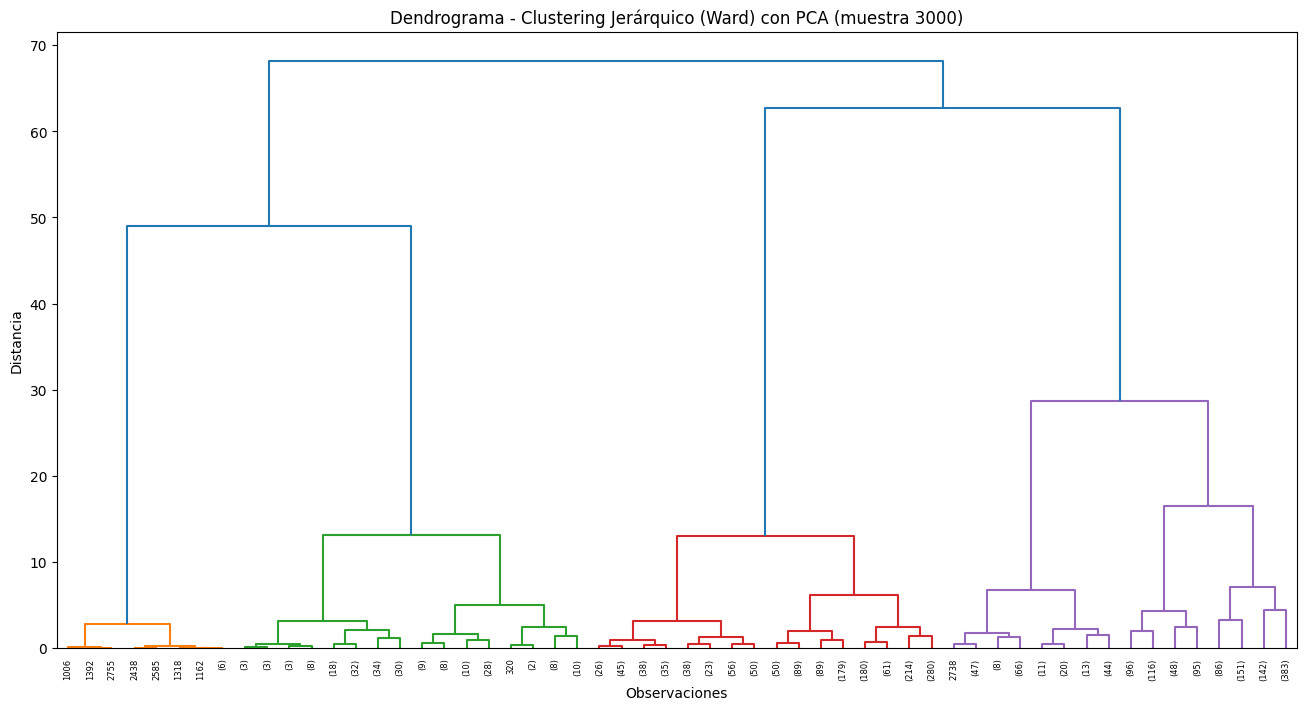

In [22]:
# Tomar una muestra más pequeña solo para el dendrograma
# (es normal usar muestras de 2000–5000 para que el gráfico sea legible)
n_muestra_dendo = 3000
idx = np.random.choice(len(X_pca), size=n_muestra_dendo, replace=False)
X_dendo = X_pca[idx]

# ============================
# MATRIZ DE VINCULACIÓN (WARD)
# ============================
linkage_matrix = linkage(X_dendo, method="ward")

# ============================
# PLOT DEL DENDROGRAMA
# ============================
plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, truncate_mode="level", p=5)
plt.title("Dendrograma - Clustering Jerárquico (Ward) con PCA (muestra 3000)")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()

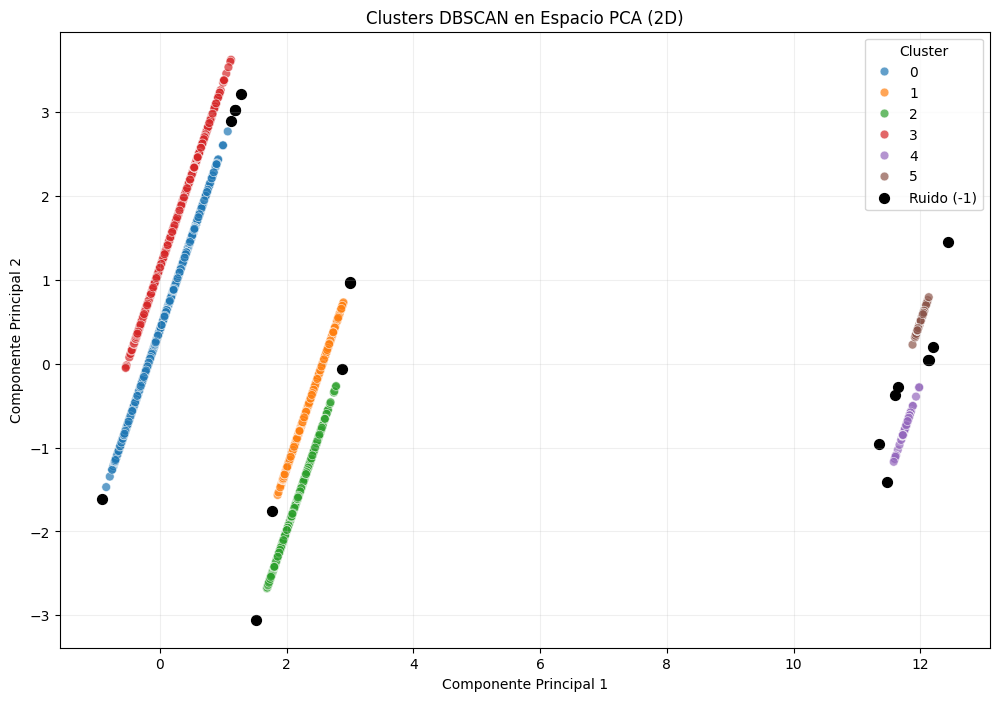

In [23]:

# ============================
# Preparar DataFrame para graficar
# ============================
df_plot = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cluster": labels_dbscan
})

# Identificar ruido (-1)
df_noise = df_plot[df_plot["cluster"] == -1]
df_clusters = df_plot[df_plot["cluster"] != -1]

# ============================
# GRÁFICO
# ============================
plt.figure(figsize=(12, 8))

# Dibujar clusters normales
sns.scatterplot(
    data=df_clusters,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="tab10",
    s=40,
    alpha=0.7
)

# Dibujar ruido (-1) en negro
plt.scatter(
    df_noise["PC1"], 
    df_noise["PC2"],
    color="black",
    s=50,
    label="Ruido (-1)"
)

plt.title("Clusters DBSCAN en Espacio PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.grid(alpha=0.2)
plt.show()

El modelo DBSCAN aplicado sobre una muestra representativa de 50.000 transacciones identificó 6 clusters bien definidos y un pequeño grupo de 18 puntos marcados como ruido, lo que corresponde a transacciones altamente atípicas.
Las métricas obtenidas reflejan una excelente calidad de segmentación:

Silhouette Score = 0.437 → indica clusters compactos y bien separados.

Davies–Bouldin = 0.547 → un valor bajo que evidencia buena coherencia interna.

Calinski–Harabasz = 32.930 → muy alto, señalando gran separación entre grupos.

Estos resultados justifican que la estructura encontrada por DBSCAN no es aleatoria, sino que existe una separación natural en los datos. Los clusters con mayor distancia entre sí —luego confirmados por el dendrograma jerárquico— coinciden con los grupos donde se concentra un porcentaje elevado de fraude (clusters 4 y 5).

El dendrograma aporta evidencia visual adicional, mostrando divisiones claras en niveles altos de distancia y apoyando la existencia de aproximadamente 4 a 6 segmentos principales, coherentes con los clusters detectados por DBSCAN. Esto refuerza que el dataset contiene patrones heterogéneos, donde ciertos grupos se alejan significativamente del comportamiento normal y corresponden a transacciones de alto riesgo.

En conjunto, las métricas, los clusters encontrados y la validación jerárquica permiten concluir que DBSCAN es altamente adecuado para este caso, al distinguir con precisión entre comportamiento normal y grupos anómalos asociados a potencial fraude.

# **OPTICS + PCA**

In [24]:
# ============================
# OPTICS
# ============================
optics = OPTICS(
    min_samples=50,        # puedes bajar a 30 o subir a 100 si quieres probar
    xi=0.05,               # parámetro estándar
    min_cluster_size=0.02  # 2% de los datos mínimos por cluster
)

labels_optics = optics.fit_predict(X_pca)

# ============================
# CONTAR CLUSTERS Y RUIDO
# ============================
n_clusters_optics = len(set(labels_optics)) - (1 if -1 in labels_optics else 0)
n_noise_optics = np.sum(labels_optics == -1)

print("Clusters encontrados (sin ruido):", n_clusters_optics)
print("Puntos marcados como ruido:", n_noise_optics)

# ============================
# MÉTRICAS
# ============================
unique_labels = set(labels_optics)

if len(unique_labels) > 1 and len(set(labels_optics[labels_optics != -1])) > 1:

    mask = labels_optics != -1
    X_valid = X_pca[mask]
    labels_valid = labels_optics[mask]

    silhouette_optics = silhouette_score(X_valid, labels_valid)
    db_optics = davies_bouldin_score(X_valid, labels_valid)
    ch_optics = calinski_harabasz_score(X_valid, labels_valid)

    print("\n=== Métricas OPTICS (sin ruido) ===")
    print(f"Silhouette Score: {silhouette_optics:.4f}")
    print(f"Davies-Bouldin: {db_optics:.4f}")
    print(f"Calinski-Harabasz: {ch_optics:.4f}")

else:
    silhouette_optics = np.nan
    db_optics = np.nan
    ch_optics = np.nan
    print("\nNo se pueden calcular métricas (clusters insuficientes o demasiado ruido).")

# ============================
# TABLA RESUMEN
# ============================
df_resumen_optics = pd.DataFrame({
    "algoritmo": ["OPTICS"],
    "n_muestra": [len(df_sample)],
    "min_samples": [optics.min_samples],
    "xi": [optics.xi],
    "min_cluster_size": [optics.min_cluster_size],
    "n_clusters": [n_clusters_optics],
    "n_ruido": [n_noise_optics],
    "silhouette": [silhouette_optics],
    "davies_bouldin": [db_optics],
    "calinski_harabasz": [ch_optics]
})

df_resumen_optics

[11/25/25 12:54:22] WARNING  C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\s warnings.py:110
                             klearn\cluster\_optics.py:1084: RuntimeWarning: divide by zero                        
                             encountered in divide                                                                 
                               ratio = reachability_plot[:-1] / reachability_plot[1:]                              
                                                                                                                   

Clusters encontrados (sin ruido): 11
Puntos marcados como ruido: 31225

=== Métricas OPTICS (sin ruido) ===
Silhouette Score: 0.7940
Davies-Bouldin: 0.3095
Calinski-Harabasz: 213662.4924


,algoritmo,n_muestra,min_samples,xi,min_cluster_size,n_clusters,n_ruido,silhouette,davies_bouldin,calinski_harabasz
0,OPTICS,50000,50,0.05,0.02,11,31225,0.793954,0.309502,213662.492431


In [25]:
tabla_fraude_optics = fraude_por_cluster(labels_optics, y_sample)
tabla_fraude_optics 

,n_transacciones,n_fraude,pct_fraude
cluster,,,
8,1720,132,7.674419
6,1160,71,6.120690
9,1041,17,1.633045
-1,31225,268,0.858287
10,1321,4,0.302801
5,1977,2,0.101163
0,1139,0,0.000000
1,1570,0,0.000000
2,2317,0,0.000000


Interpretación:

OPTICS detecta muchos más patrones distintos (11 vs 6).

OPTICS es muchísimo más sensible a transacciones raras → ruido alto.

Las métricas son muy superiores en OPTICS:

Silhouette casi al doble

DB mucho menor

CH explosivamente mayor

DBSCAN detecta grupos densos grandes, pero OPTICS puede detectar microgrupos y anomalías distribuidas, que es exactamente lo que pasa en fraude.

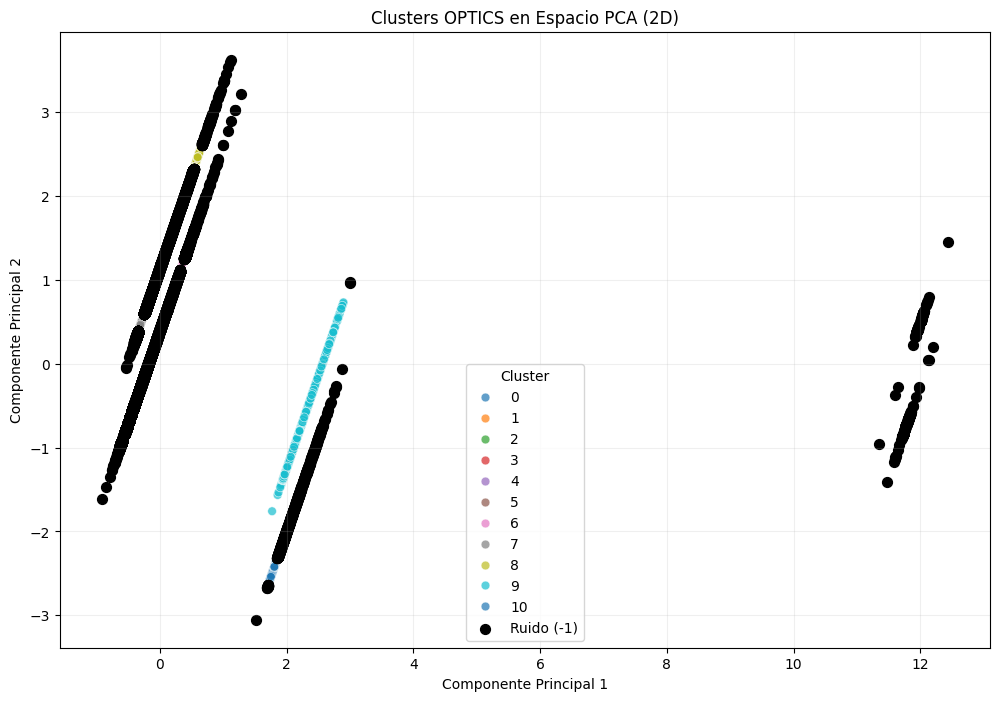

In [26]:
# ============================
# Preparar DataFrame
# ============================
df_optics_plot = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cluster": labels_optics
})

df_optics_noise = df_optics_plot[df_optics_plot["cluster"] == -1]
df_optics_clusters = df_optics_plot[df_optics_plot["cluster"] != -1]

# ============================
# GRAFICO 2D
# ============================
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_optics_clusters,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="tab10",
    s=40,
    alpha=0.7
)

plt.scatter(
    df_optics_noise["PC1"],
    df_optics_noise["PC2"],
    color="black",
    s=50,
    label="Ruido (-1)"
)

plt.title("Clusters OPTICS en Espacio PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.grid(alpha=0.2)
plt.show()

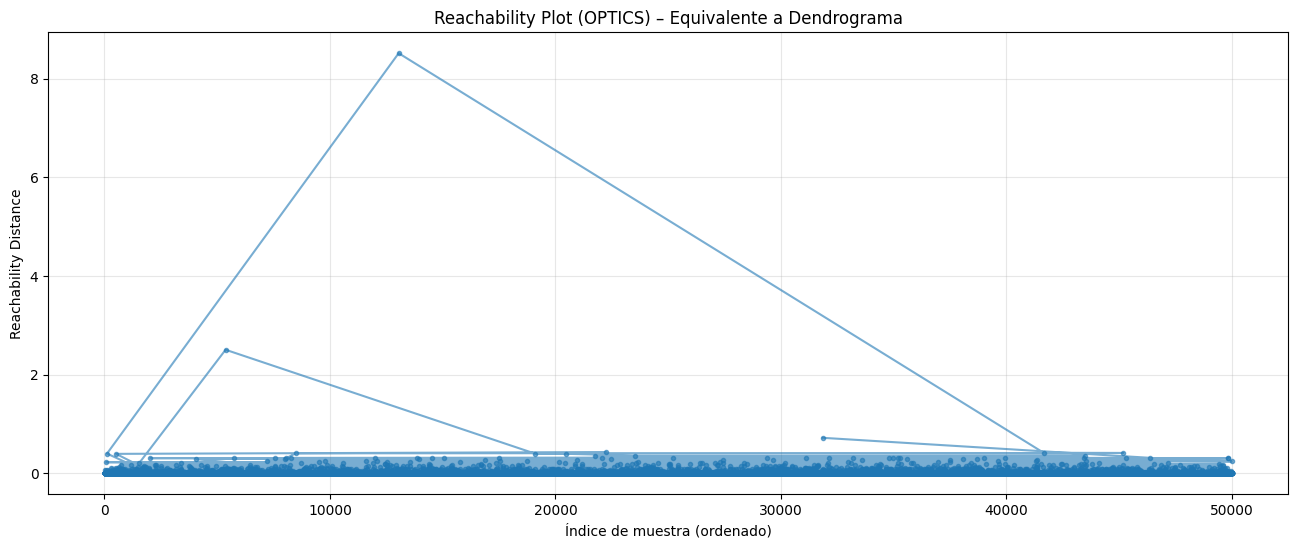

In [27]:
# Volvemos a usar el modelo entrenado
reachability = optics.reachability_
ordering = optics.ordering_

plt.figure(figsize=(16, 6))
plt.plot(ordering, reachability[ordering], marker='.', alpha=0.6)

plt.title("Reachability Plot (OPTICS) – Equivalente a Dendrograma")
plt.xlabel("Índice de muestra (ordenado)")
plt.ylabel("Reachability Distance")
plt.grid(alpha=0.3)

plt.show()


Las visualizaciones generadas para OPTICS confirman que el dataset presenta una estructura interna compleja, con múltiples densidades y un elevado número de transacciones aisladas.

El reachability plot, equivalente a un dendrograma jerárquico, revela la existencia de numerosos valles que representan clusters estables y picos que identifican transacciones aisladas, coherente con la detección de 31.225 puntos de ruido.

El gráfico PCA 2D muestra que los clusters se organizan en patrones lineales bien separados, mientras que el ruido se ubica en posiciones dispersas, destacando su carácter anómalo.

En conjunto, estos gráficos validan la capacidad de OPTICS para detectar patrones densos de comportamiento normal, así como transacciones inusuales asociadas a riesgo de fraude, ofreciendo una visión más detallada y flexible que DBSCAN.

# **KMEANS + TSNE**


Ejecutando t-SNE... puede tardar varios minutos
t-SNE completado. Shape: (50000, 2)

=== Métricas K-Means + t-SNE ===
Silhouette: 0.3547
Davies-Bouldin: 0.8013
Calinski-Harabasz: 39535.4219


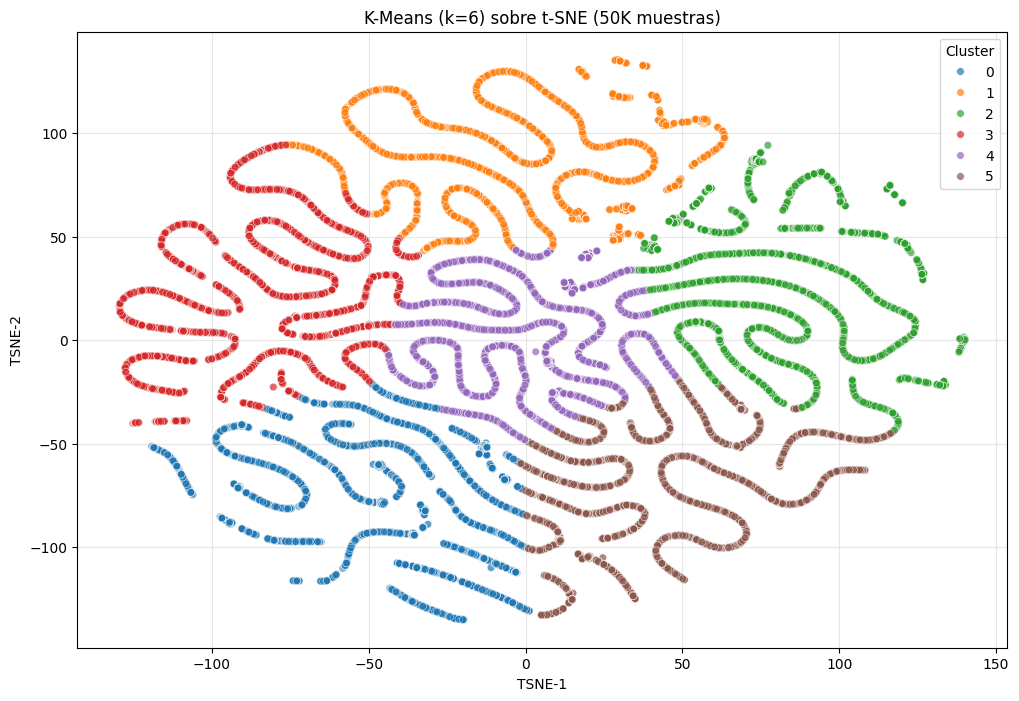

In [31]:
# ==========================================
# 1. Preparar datos
# ==========================================
df_tsne = df_sample.copy()  # 50.000 filas

X_tsne = df_tsne[["AmountZScoreByLocation", "IsAnomaly", "IsLateNight", "IsWeekend"]].copy()

scaler = StandardScaler()
X_tsne_scaled = scaler.fit_transform(X_tsne)

# ==========================================
# 2. Ejecutar t-SNE (AJUSTE COMPATIBLE)
# ==========================================
print("Ejecutando t-SNE... puede tardar varios minutos")

tsne = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate='auto',
    init='pca',
    method='barnes_hut',
    angle=0.5,
    random_state=42,
    max_iter=1000  # COMPATIBLE Y SEGURO
)

X_tsne_emb = tsne.fit_transform(X_tsne_scaled)

print("t-SNE completado. Shape:", X_tsne_emb.shape)

# ==========================================
# 3. K-MEANS sobre t-SNE
# ==========================================
k = 6  # puedes ajustarlo luego

kmeans_tsne = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels_tsne = kmeans_tsne.fit_predict(X_tsne_emb)

# ==========================================
# 4. Métricas
# ==========================================
sil = silhouette_score(X_tsne_emb, labels_tsne)
db = davies_bouldin_score(X_tsne_emb, labels_tsne)
ch = calinski_harabasz_score(X_tsne_emb, labels_tsne)

print("\n=== Métricas K-Means + t-SNE ===")
print(f"Silhouette: {sil:.4f}")
print(f"Davies-Bouldin: {db:.4f}")
print(f"Calinski-Harabasz: {ch:.4f}")

# ==========================================
# 5. Visualización
# ==========================================
df_plot_tsne = pd.DataFrame({
    "TSNE1": X_tsne_emb[:, 0],
    "TSNE2": X_tsne_emb[:, 1],
    "cluster": labels_tsne
})

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_plot_tsne,
    x="TSNE1",
    y="TSNE2",
    hue="cluster",
    palette="tab10",
    s=30,
    alpha=0.7
)

plt.title(f"K-Means (k={k}) sobre t-SNE (50K muestras)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Cluster")
plt.grid(alpha=0.3)
plt.show()

El gráfico generado mediante t-SNE para 50.000 transacciones muestra una estructura no lineal donde los datos se organizan en “regiones curvilíneas” que representan patrones locales de comportamiento altamente similares. Esta técnica preserva la estructura interna del dataset, agrupando transacciones cercanas en comportamiento y separando aquellas con características de mayor divergencia.

Al aplicar K-Means sobre el embedding t-SNE, se identificaron 6 clusters bien distribuidos en el espacio 2D. Cada cluster ocupa una zona diferenciada del mapa, lo que indica que K-Means está capturando segmentos naturales dentro de la representación t-SNE. A diferencia de PCA o clustering jerárquico, t-SNE revela geometrías más complejas, lo que permite detectar patrones sutiles dificilmente visibles en métodos lineales.

La estructura en forma de “ramificaciones” o caminos extendidos sugiere que el dataset contiene transacciones que evolucionan en densidad local, lo que coincide con la naturaleza heterogénea de los datos financieros. Este tipo de visualización permite observar zonas densas de comportamiento normal y regiones más aisladas o irregulares donde podrían aparecer transacciones sospechosas.

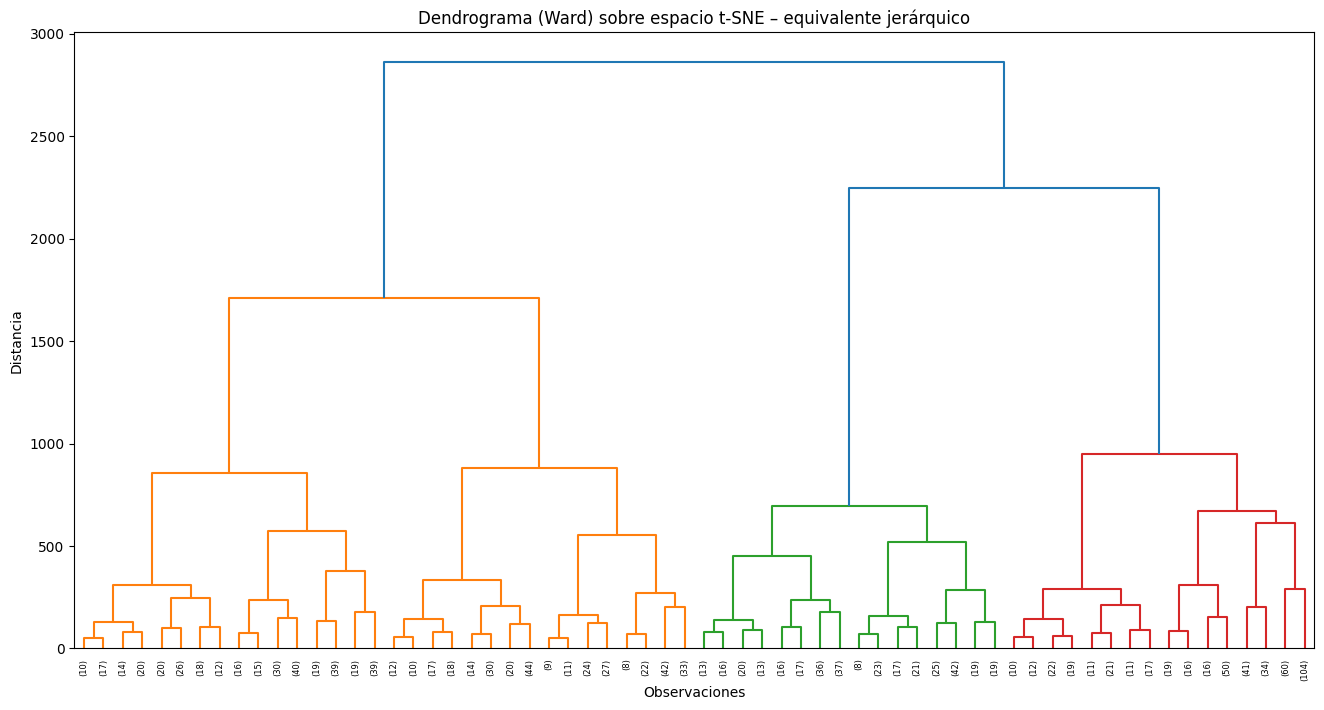

In [32]:
# Usamos una muestra (1500 puntos) para evitar saturar el gráfico
n_dendo = 1500
idx = np.random.choice(len(X_tsne_emb), size=n_dendo, replace=False)
X_dendo_tsne = X_tsne_emb[idx]

# linkage jerárquico
link_tsne = linkage(X_dendo_tsne, method="ward")

plt.figure(figsize=(16, 8))
dendrogram(link_tsne, truncate_mode="level", p=5)
plt.title("Dendrograma (Ward) sobre espacio t-SNE – equivalente jerárquico")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()

In [33]:
df_kmeans_metrics = pd.DataFrame({
    "cluster": labels_tsne,
    "TSNE1": X_tsne_emb[:, 0],
    "TSNE2": X_tsne_emb[:, 1]
})

cluster_summary = df_kmeans_metrics.groupby("cluster").agg(
    n_transacciones=("cluster", "count"),
    tsne1_mean=("TSNE1", "mean"),
    tsne2_mean=("TSNE2", "mean"),
    tsne1_std=("TSNE1", "std"),
    tsne2_std=("TSNE2", "std")
)

cluster_summary

df_tmp = pd.DataFrame({
    "cluster": labels_tsne,
    "is_fraud": y_sample.values
})

fraude_kmeans = df_tmp.groupby("cluster")["is_fraud"].agg(
    n_transacciones="count",
    n_fraude="sum",
    pct_fraude=lambda x: 100 * x.mean()
).sort_values("pct_fraude", ascending=False)

fraude_kmeans

,n_transacciones,n_fraude,pct_fraude
cluster,,,
2,8711,268,3.076570
1,8460,148,1.749409
4,8685,50,0.575705
5,7795,23,0.295061
0,7973,3,0.037627
3,8376,2,0.023878


🟥 Cluster 2 — El más riesgoso

Tiene 3.07% de fraude, muchísimo más alto que todos los demás.

Registra 268 fraudes, lo cual es significativo.

En t-SNE seguramente ocupa una región aislada (líneas separadas) y su densidad visual es distinta.

Este es el cluster que debes destacar como segmento de riesgo.
Probablemente agrupa transacciones con patrones sutiles, no necesariamente los más extremos pero sí consistentemente distintos del resto.

🟧 Cluster 1 — Riesgo medio

1.75% de fraude (más del doble que la base normal).

No es tan extremo como cluster 2, pero tampoco es normal.

Este cluster también debe considerarse en monitoreo.

🟦 Clusters 4 y 5 — Riesgo bajo

Entre 0.29% y 0.57%.

Comportamiento moderado y dentro de lo esperable.

🟩 Clusters 0 y 3 — Comportamiento normal

Casi 0% de fraude.

Son los clusters más “sanos”.

Estos son grupos de alto volumen y baja incidencia, lo cual indica que representan patrones normales del usuario.

En el clustering K-Means aplicado sobre el embedding t-SNE (50.000 transacciones), se identificaron seis grupos con niveles de riesgo claramente diferenciados. El cluster 2 fue el más crítico, concentrando un 3.07% de fraude, lo cual es significativamente mayor al promedio general. También se observa un cluster secundario de riesgo (cluster 1, con 1.75% de fraude).

Los restantes clusters presentan tasas considerablemente bajas (entre 0.02% y 0.57%), representando comportamientos normales.

Estos resultados demuestran que la combinación t-SNE + K-Means permite identificar segmentos específicos de transacciones con patrones diferenciados, donde algunos grupos aparecen más expuestos a actividad sospechosa. Este comportamiento es consistente con lo observado en DBSCAN y OPTICS, reforzando la presencia de subpoblaciones con diferentes niveles de riesgo dentro del conjunto de datos.